This notebook is an analysis of the errors in relative free energy calculations on the Schrödinger JACS dataset:
> Wang, L., Wu, Y., Deng, Y., Kim, B., Pierce, L., Krilov, G., ... & Romero, D. L. (2015). Accurate and reliable prediction of relative ligand binding potency in prospective drug discovery by way of a modern free-energy calculation protocol and force field. Journal of the American Chemical Society, 137(7), 2695-2703.

http://doi.org/10.1021/ja512751q

as reported in the AMBER TI chemRixv manuscript:

> Validation of AMBER/GAFF for Relative Free Energy Calculations
Preprint submitted on 02.02.2019, 15:29 and posted on 04.02.2019, 15:08 by Lin Song Tai-Sung Lee Chun Zhu Darrin M. York Kenneth M. Merz Jr.

https://chemrxiv.org/articles/Validation_of_AMBER_GAFF_for_Relative_Free_Energy_Calculations/7653434

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import sklearn.metrics
import scipy.stats

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

def read_dataset():
    """Read the dataset
    
    Code from Pat Walters:
    https://github.com/PatWalters/FEP_TI_Comparison/blob/master/fep_ti_analysis.ipynb

    Returns
    -------
    master_df : pandas.Dataframe
       dataframe containing DeltaG values (kcal/mol) for all targets
    """
    def get_data_from_sheet(xls,sheet_name,col_names):
        df = xls.parse(sheet_name=sheet_name,header=None)
        df = df[df.columns[15:18]]
        df.columns = col_names
        df.dropna(inplace=True)
        df = df.query("EXP > -20")
        rows,_ = df.shape
        df.insert(0,"Target",[sheet_name]*rows)
        df.insert(1,"ID",[f"{sheet_name}_{x}" for x in range(0,rows)])
        return df

    xls = pd.ExcelFile("amber-ti/FEP_vs_GTI-dG-SI.xlsx")
    sheet_names = xls.sheet_names

    col_names = ["EXP","FEP","TI"]
    master_df = pd.DataFrame(columns=["Target","ID"]+col_names)
    for sheet in sheet_names:
        tmp_df = get_data_from_sheet(xls,sheet,col_names)
        master_df = master_df.append(tmp_df)   
    master_df.sort_values("Target",inplace=True)

    return master_df

df = read_dataset()

targets = df['Target'].unique()
print(targets)

df.head()

['bace' 'cdk2' 'jnk1' 'mcl1' 'p38a' 'ptp1b' 'thrombin' 'tyk2']


,Target,ID,EXP,FEP,TI
12,bace,bace_12,-8.53,-6.76,-8.27
30,bace,bace_30,-7.84,-7.40,-7.40
29,bace,bace_29,-9.01,-7.93,-7.80
28,bace,bace_28,-8.25,-7.01,-9.72
27,bace,bace_27,-9.10,-10.14,-10.16


In [3]:
def bootstrap_statistic(y_true, y_pred, ci=0.95, statistic='RMSE', nbootstrap = 1000, plot_type='dG'):
    """Compute mean and confidence intervals of specified statistic.
    
    Parameters
    ----------
    y_true : ndarray with shape (N,)
        True values
    y_pred : ndarray with shape (N,)
        Predicted values
    ci : float, optional, default=0.95
        Interval for CI
    statistic : str
        Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
    nbootstrap : int, optional, default=1000
        Number of bootstrap samples
    plot_type : str, optional, default='dG'
        'dG' or 'ddG'
        
    Returns
    -------
    rmse_stats : dict of floeat
        'mean' : mean RMSE
        'stderr' : standard error
        'low' : low end of CI
        'high' : high end of CI
    """
    
    def compute_statistic(y_true_sample, y_pred_sample, statistic):
        """Compute requested statistic.
        
        Parameters
        ----------
        y_true : ndarray with shape (N,)
            True values
        y_pred : ndarray with shape (N,)
            Predicted values
        statistic : str
            Statistic, one of ['RMSE', 'MUE', 'R2', 'rho']
            
        """
        if statistic == 'RMSE':
            return np.sqrt(sklearn.metrics.mean_squared_error(y_true_sample, y_pred_sample))
        elif statistic == 'MUE':
            return sklearn.metrics.mean_absolute_error(y_true_sample, y_pred_sample)
        elif statistic == 'R2':
            return sklearn.metrics.r2_score(y_true_sample, y_pred_sample)
        elif statistic == 'rho':
            return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
        else:
            raise Exception("unknown statistic '{}'".format(statistic))
            
    def unique_differences(x):
        """Compute all unique differences"""
        N = len(x)
        return np.array( [ (x[i] - x[j]) for i in range(N) for j in range(N) if (i != j) ] )        
            
    assert len(y_true) == len(y_pred)
    sample_size = len(y_true)
    s_n = np.zeros([nbootstrap], np.float64) # s_n[n] is the statistic computed for bootstrap sample n
    for replicate in range(nbootstrap):
        indices = np.random.choice(np.arange(sample_size), size=[sample_size])
        if plot_type == 'dG':
            y_true_sample, y_pred_sample = y_true[indices], y_pred[indices]
        elif plot_type == 'ddG':
            y_true_sample, y_pred_sample = unique_differences(y_true[indices]), unique_differences(y_pred[indices])
        s_n[replicate] = compute_statistic(y_true_sample, y_pred_sample, statistic)
                
    rmse_stats = dict()
    if plot_type == 'dG':
        rmse_stats['mean'] = compute_statistic(y_true, y_pred, statistic)
    elif plot_type == 'ddG':
        rmse_stats['mean'] = compute_statistic(unique_pairs(y_true), unique_pairs(y_pred), statistic)        
    rmse_stats['stderr'] = np.std(s_n)
    
    # TODO: Is there a canned method to do this?
    s_n = np.sort(s_n)
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    rmse_stats['low'] = s_n[int(np.floor(nbootstrap*low_frac))]
    rmse_stats['high'] = s_n[int(np.ceil(nbootstrap*high_frac))]

    return rmse_stats

In [4]:
def bootstrap_sign_prediction(DeltaG_predicted, DeltaG_experimental, threshold, ci=0.95, nbootstrap = 1000):
    """Compute mean and confidence intervals for predicting correct sign.
    
    Parameters
    ----------
    DeltaG_predicted : numpy array with dimensions (Nligands,)
        Predicted free energies (kcal/mol)
    DeltaG_experimental : numpy array with dimensions (Nligands,)
        Experimental free energies (kcal/mol)
    threshold : float
        Threshold in free energy (kcal/mol)
    ci : float, optional, default=0.95
        Interval for CI
    nbootstrap : int, optional. default=10000
        Number of bootstrap samples
        
    Returns
    -------
    mean : float
        The mean statistic for the whole dataset
    stderr : float
        The standard error
    low, high : float
        Low and high ends of CI    
    """
    
    def compute_fraction(DeltaG_predicted, DeltaG_experimental, threshold):
        # Compute all differences
        N = len(DeltaG_predicted)        
        DDG_predicted = np.zeros([N*(N-1)], np.float64)
        DDG_experimental = np.zeros([N*(N-1)], np.float64)
        index = 0
        for i in range(N):
            for j in range(N):
                if i != j:
                    DDG_predicted[index] = (DeltaG_predicted[j] - DeltaG_predicted[i])
                    DDG_experimental[index] = (DeltaG_experimental[j] - DeltaG_experimental[i])
                    index += 1
        indices = np.where(np.abs(DDG_predicted) > threshold)[0]
        return np.sum(np.sign(DDG_predicted[indices]) == np.sign(DDG_experimental[indices])) / float(len(indices))
            
    N_ligands = len(DeltaG_predicted)
    fraction_n = np.zeros([nbootstrap], np.float64)
    for replicate in range(nbootstrap):
        bootstrapped_sample = np.random.choice(np.arange(N_ligands), size=[N_ligands])
        fraction_n[replicate] = compute_fraction(DeltaG_predicted[bootstrapped_sample], DeltaG_experimental[bootstrapped_sample], threshold)
        
    fraction_n = np.sort(fraction_n)
        
    fraction = compute_fraction(DeltaG_predicted, DeltaG_experimental, threshold)
    dfraction = np.std(fraction_n)
    
    low_frac = (1.0-ci)/2.0
    high_frac = 1.0 - low_frac
    fraction_low = fraction_n[int(np.floor(nbootstrap*low_frac))]
    fraction_high = fraction_n[int(np.ceil(nbootstrap*high_frac))]

    return fraction, dfraction, fraction_low, fraction_high

In [5]:
# Plot data by system
def plot_data(rows, title):
    """
    Plot predicted vs experimental fraction correct
    
    Parameters
    ----------
    title : str
        Plot title
    rows : pd.Dataframe
        Pandas dataframe containing 'EXP', 'FEP', and 'TI' columns
        
    """    
    nsamples = len(rows['EXP'].values)
    methods = ('EXP', 'FEP', 'TI')
            
    plt.xlabel('$\Delta \Delta G$ threshold (kcal/mol)');
    plt.ylabel('fraction correctly predicted');

    [min_threshold, max_threshold] = [0, 2]
    fractions = dict()
    dfractions = dict()
    fractions_low = dict()
    fractions_high = dict()
    thresholds = np.linspace(min_threshold, max_threshold, 20)
    handles = dict()
    for method in ['FEP', 'TI']:
        fractions[method] = thresholds * 0.0
        dfractions[method] = thresholds * 0.0
        fractions_low[method] = thresholds * 0.0
        fractions_high[method] = thresholds * 0.0
        for index, threshold in enumerate(thresholds):            
            fractions[method][index], dfractions[method][index], fractions_low[method][index], fractions_high[method][index] = bootstrap_sign_prediction(rows[method].values, rows['EXP'].values, threshold)
        handles[method] = plt.plot(thresholds, fractions[method]);
        plt.fill_between(thresholds, fractions_low[method], fractions_high[method], alpha=0.5, color=handles[method][0].get_color())

    plt.legend([handles['FEP'][0], handles['TI'][0]], ['OPLS3', 'GAFF'])
    
    # Label plot
    title = """{} (N = {})""".format(title, nsamples)
    plt.title(title, fontsize=11, family='monospace');
    
    plt.xlim(min_threshold, max_threshold);
    plt.ylim(0, 1);

bace
cdk2


/Users/choderaj/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


jnk1
mcl1
p38a
ptp1b
thrombin
tyk2


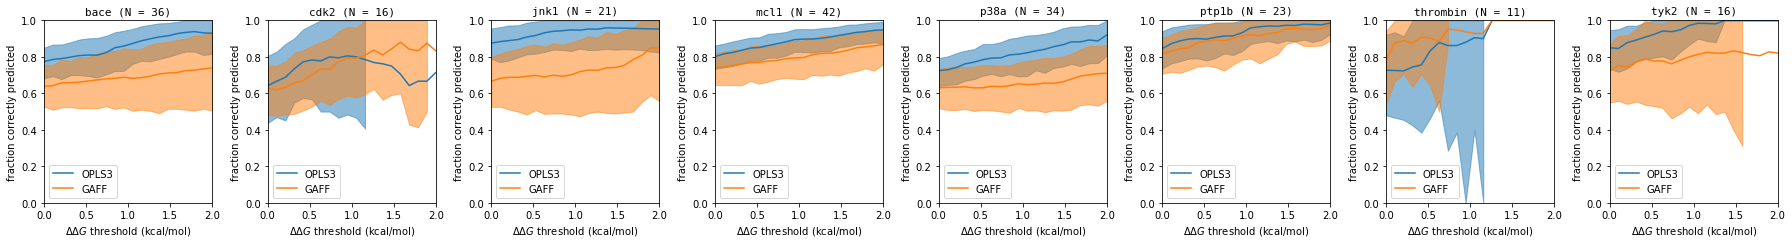

In [6]:
# Plot dG
ny = 1
nx = len(targets)
fig = plt.figure(figsize=[25,3.5])
plot_index = 1
for target, rows in df.groupby("Target"):   
    print(target)
    plt.subplot(ny, nx, plot_index)
    plot_data(rows, target)
    plot_index += 1

# Write out figure to a file
fig.tight_layout()
fig.savefig('opls3-vs-gaff-fraction-correct.pdf', dpi=300);
fig.savefig('opls3-vs-gaff-fraction-correct.png', dpi=300);